### Imports

In [1]:
import numpy as np
from specmf.models import Graph, MultiFidelityModel
from specmf.utils import error_analysis, val_test_split
from specmf.data import load_data
from specmf.plot import *

In [2]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>

### Data loading

In [3]:
dataset_name = "inclusion-qoi"

x_LF, x_HF, normalization_vars = load_data(
        dataset_name,
        preprocess=True,
        normalize=True,
        return_normalization_vars=True,
        flatten=True,
)

print(f"{x_LF.shape=}", f"{x_HF.shape=}")

Loading inclusion QoIs data ...
x_LF.shape=(5835, 5) x_HF.shape=(5835, 5)


### Plot data 

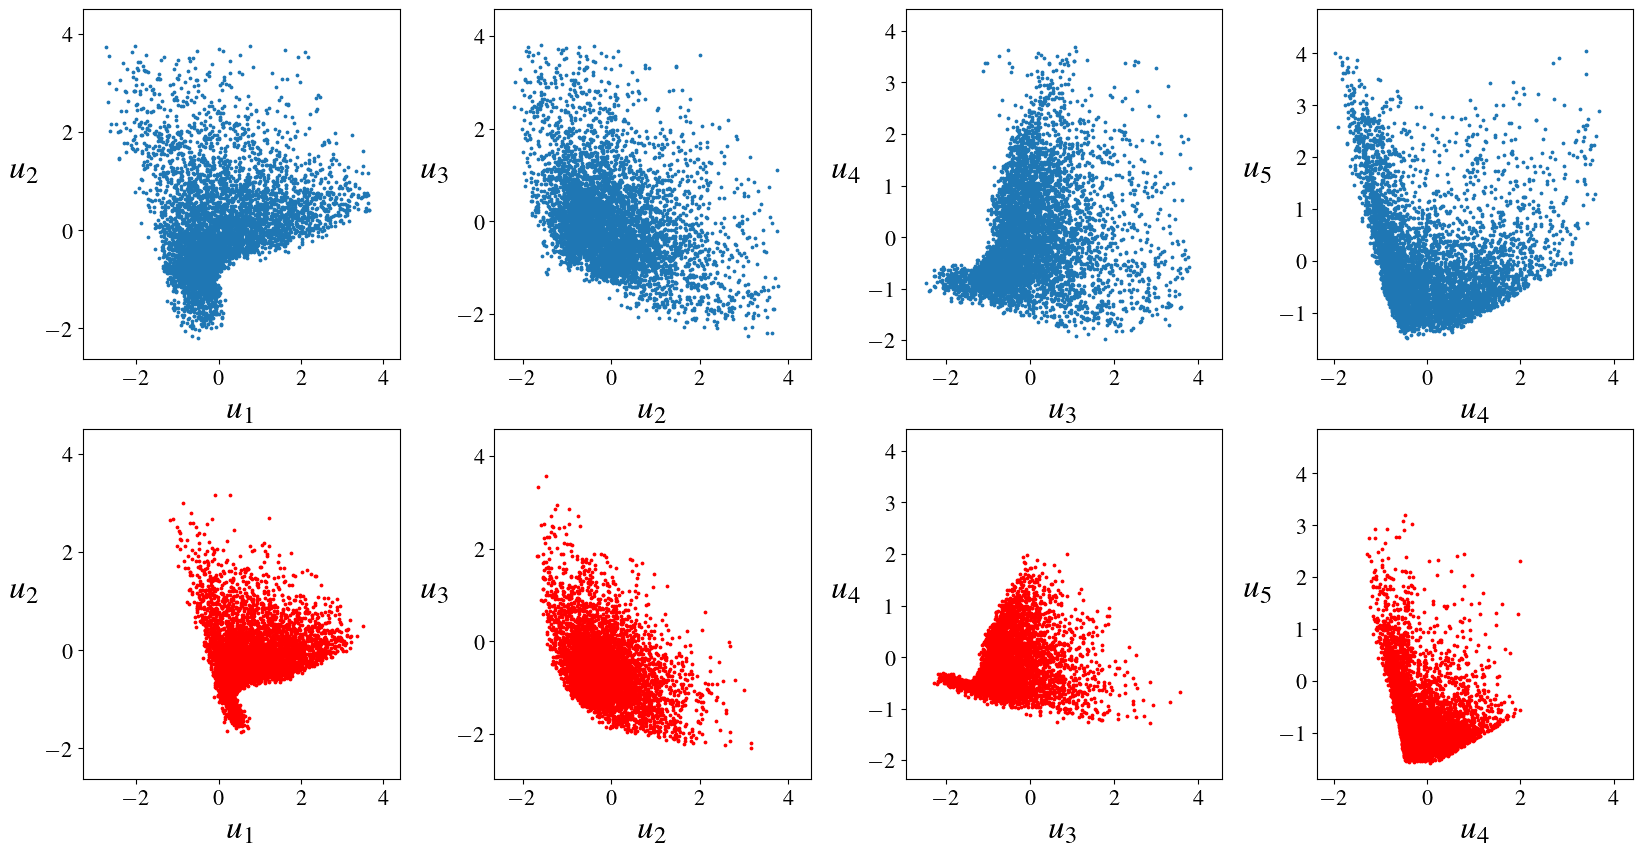

In [4]:
plot_data(x_LF, x_HF, dataset_name)

### Multi-fidelity model

#### Create graph and model instances

In [5]:
# Create the graph
graph_config = {
    'metric': 'euclidean',
    'dist_space': 'ambient',
    'n_components': None,
    'method': 'full',
    'k_nn': None,
    'corr_scale': None,
    'k_adj': 7,
    'p': 0.5,
    'q': 0.5,
}
g_LF = Graph(data=x_LF, **graph_config)

# Create the model 
model_config = {
    'sigma': 0.01,
    'method': 'full',
}
model = MultiFidelityModel(**model_config)

#### Perform spectral clustering

In [6]:
n_HF = 150
inds_train, labels = model.cluster(g_LF, n_HF)

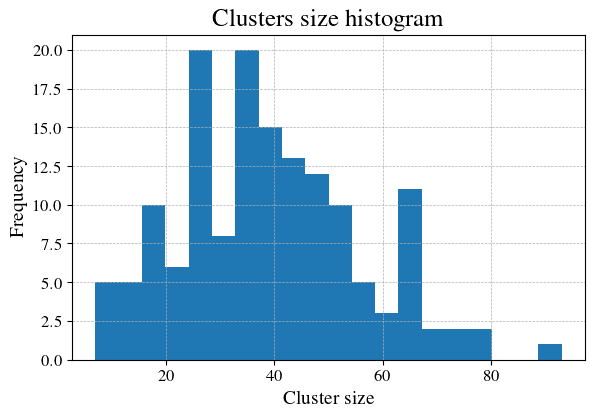

In [7]:
plot_cluster_size_hist(labels)

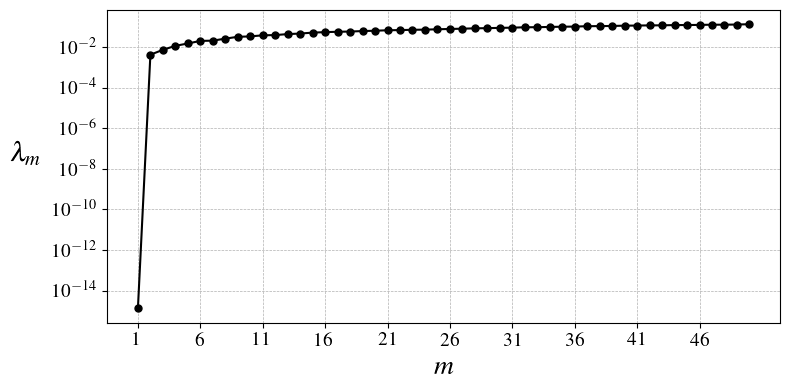

In [8]:
# Plot Laplacian spectrum
eigvals, eigvecs = g_LF.laplacian_eig()
plot_spectrum(eigvals, 50)

#### Split high-fidelity data

In [9]:
inds_val, inds_test = val_test_split(n_data=x_HF.shape[0], 
                                     inds_train=inds_train, 
                                     split_ratio=0.009)

x_HF_train = x_HF[inds_train, :]
x_HF_val = x_HF[inds_val, :]
x_HF_test = x_HF[inds_test, :]

print(f"{x_HF_train.shape=}", f"{x_HF_val.shape=}", f"{x_HF_test.shape=}")

x_HF_train.shape=(150, 5) x_HF_val.shape=(51, 5) x_HF_test.shape=(5634, 5)


#### Hyper-parameters search

In [10]:
train = False

In [11]:
def cost_fn(kappa):
    """
    Custom cost function for the optimization.
    """
    # Create the model 
    model_config = {
        'sigma': 0.01,
        'method': 'full',
    }
    model = MultiFidelityModel(**model_config)

    model.kappa = kappa

    x_MF, _, dPhi = model.transform(g_LF, x_HF_train, inds_train)
    x_LF = g_LF.nodes
    _, e_MF = error_analysis(
        x_LF[inds_val],
        x_MF[inds_val],
        x_HF_val,
        return_values=True,
        verbose=0,
    )
    return np.mean(e_MF), np.mean(dPhi)


def train_loop(kappas):
    """
    Train the model for a range of kappa values.
    """
    errors = []
    dPhis = []
    for kappa in kappas:
        error, dPhi = cost_fn(kappa)
        errors.append(error)
        dPhis.append(dPhi)
    return errors, dPhis

In [12]:
if train:

    # Loop thru kappas
    kappas = np.logspace(-12, 6, 50)
    errors, dPhis = train_loop(kappas)

    # Find the optimal kappa
    ind_opt = np.argmin(np.abs(np.array(dPhis) - 3 * model_config["sigma"]))
    kappa_opt = kappas[ind_opt]
    print(f"Optimal kappa = {kappa_opt}")

    # Plots
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Plot the first set of data
    ax1.plot(kappas, errors , 'b-')
    ax1.set_xscale('log')
    ax1.set_xlabel(r'$\kappa$', fontsize=14)
    ax1.set_ylabel('error', color='b', fontsize=14)
    ax1.tick_params(axis='y', labelcolor='b')

    # Create a twin axis sharing the same x-axis
    ax2 = ax1.twinx()

    # Plot the second set of data
    ax2.plot(kappas, dPhis, 'r-')
    ax2.set_yscale('log')
    ax2.set_ylabel(r'$\mathrm{mean}(\sqrt{C_{ii}})$', color='r', rotation=0, labelpad=50, fontsize=14)
    ax2.tick_params(axis='y', labelcolor='r')

    ax1.plot([kappa_opt, kappa_opt], [12, 65], 'k--')
    ax2.grid('on')

    plt.title('Soft body traction data')

In [13]:
if not train:

    import yaml
    from pathlib import Path

    notebook_path = Path.cwd()
    yaml_file_path = notebook_path.parent / 'data/model_configs.yaml'
    with open(yaml_file_path, 'r') as file:
        MODEL_CONFIG = yaml.safe_load(file)

    kappa_opt = MODEL_CONFIG["inclusion-qoi"]["model_config"]["kappa"]
    print(f"Optimal kappa = {kappa_opt}")

Optimal kappa = 0.045


#### Train the model with optimized hyperprameters

In [14]:
best_config = {
    'kappa': kappa_opt,
}

model_config.update(best_config)
model = MultiFidelityModel(**model_config)

In [15]:
x_MF, C_phi, dPhi = model.transform(g_LF, x_HF_train, inds_train)
model.summary()

Model Configuration:
sigma                   : 0.01
beta                    : 2
kappa                   : 0.045
omega                   : 2480.409386630173
method                  : full
spectrum_cutoff         : None
tau                     : 0.004259362213710286
n_clusters              : None
_is_graph_clustered     : False


Text(0.5, 1.0, 'Variance histogram for Soft body traction data')

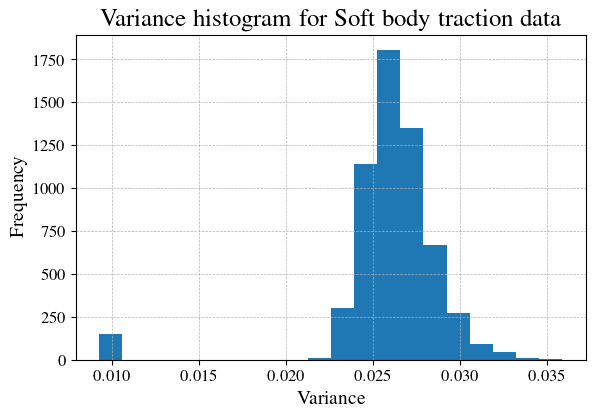

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(dPhi, bins=20)
ax.set_xlabel("Variance", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
ax.tick_params(axis="both", labelsize=12)
ax.set_title("Variance histogram for Soft body traction data", fontsize=18)

### Results

In [17]:
# Error Analysis for validation datadet
error_analysis(x_LF[inds_val], x_MF[inds_val], x_HF_val, component_wise=True,)

Component-wise mean relative l2 errors and Improvement Factor (IF)
-------------------------------------------------------------------
Error LF:         [ 83.38  56.06  72.17 111.5   66.45]
Error MF:         [13.8  14.83 16.48 20.52 19.33]
Percentage drop:  [83.45 73.54 77.17 81.6  70.91]%


In [18]:
# Error Analysis for unseen test datadet
error_analysis(x_LF[inds_test], x_MF[inds_test], x_HF_test, component_wise=True,)

Component-wise mean relative l2 errors and Improvement Factor (IF)
-------------------------------------------------------------------
Error LF:         [99.12 62.6  75.78 92.21 76.52]
Error MF:         [16.19 19.45 16.96 18.51 23.85]
Percentage drop:  [83.67 68.94 77.62 79.93 68.83]%


In [19]:
# Error Analysis for the whole dataset
error_analysis(x_LF, x_MF, x_HF, component_wise=True,)

Component-wise mean relative l2 errors and Improvement Factor (IF)
-------------------------------------------------------------------
Error LF:         [98.51 62.55 75.53 92.62 76.45]
Error MF:         [15.74 18.92 16.53 18.09 23.24]
Percentage drop:  [84.03 69.75 78.12 80.47 69.6 ]%


In [20]:
# Error Analysis for the whole dataset in ambient space
X_mean = normalization_vars['X_mean']
X_scale = normalization_vars['X_scale']

X_LF = x_LF * X_scale + X_mean
X_HF = x_HF * X_scale + X_mean
X_MF = x_MF * X_scale + X_mean

error_analysis(X_LF, X_MF, X_HF, component_wise=True,)

Component-wise mean relative l2 errors and Improvement Factor (IF)
-------------------------------------------------------------------
Error LF:         [ 5.74  4.8   7.57  4.93 11.04]
Error MF:         [0.92 1.45 1.66 0.96 3.36]
Percentage drop:  [84.03 69.75 78.12 80.47 69.6 ]%


In [21]:
eLF, eMF = error_analysis(X_LF, X_MF, X_HF, component_wise=True, return_values=True,)


Component-wise mean relative l2 errors and Improvement Factor (IF)
-------------------------------------------------------------------
Error LF:         [ 5.74  4.8   7.57  4.93 11.04]
Error MF:         [0.92 1.45 1.66 0.96 3.36]
Percentage drop:  [84.03 69.75 78.12 80.47 69.6 ]%


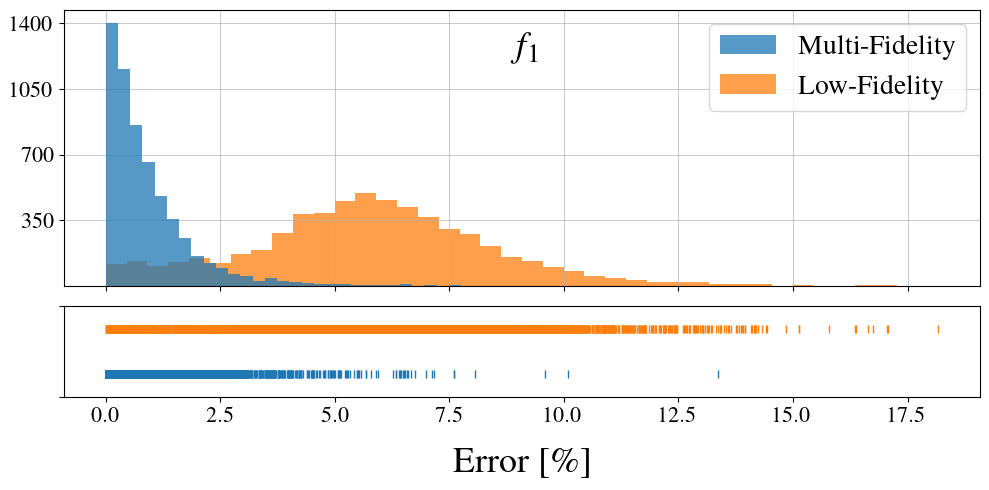

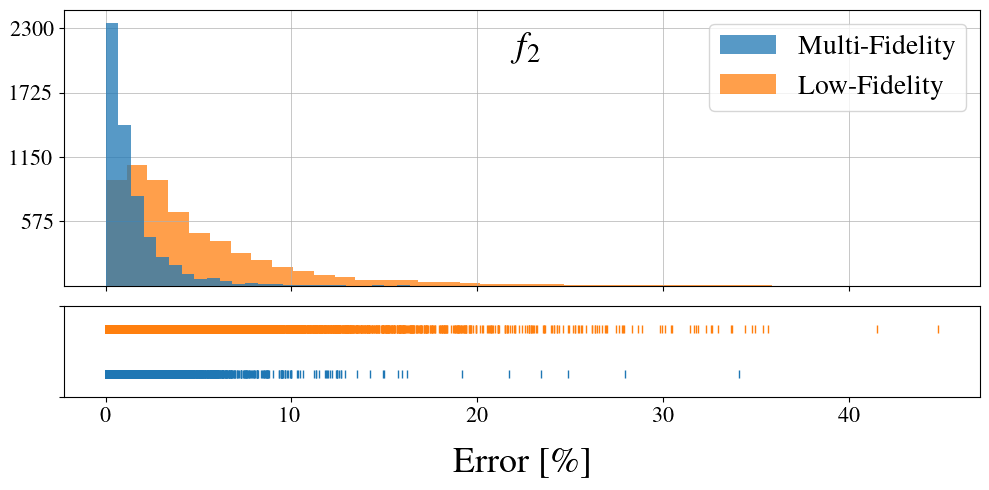

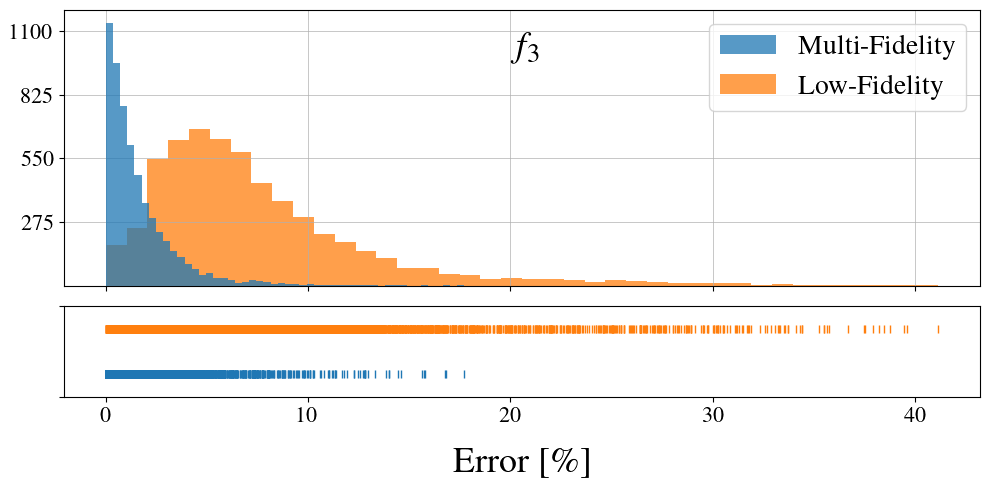

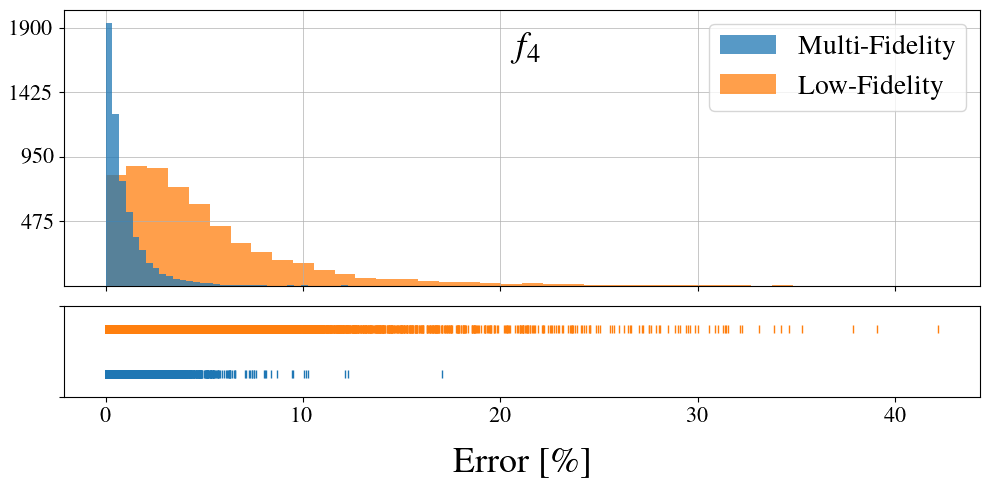

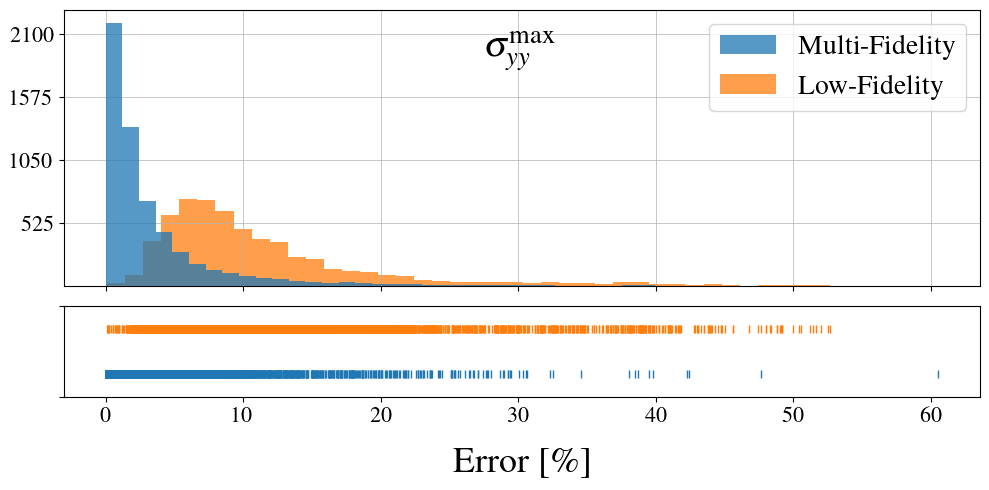

In [22]:
comps = [r"$f_1$", r"$f_2$", r"$f_3$", r"$f_4$", r"$\sigma_{yy}^{\mathrm{max}}$"]
for i in range(5):
    E_LF = 100 * np.linalg.norm(X_LF[:, i:i+1] - X_HF[:, i:i+1], axis=1) / (np.mean(np.linalg.norm(X_HF[:, i:i+1], axis=1)) + 1e-3)
    E_MF = 100 * np.linalg.norm(X_MF[:, i:i+1] - X_HF[:, i:i+1], axis=1) / (np.mean(np.linalg.norm(X_HF[:, i:i+1], axis=1)) + 1e-3)

    axs = plot_distributions(E_LF, E_MF, bins_LF=40, bins_MF=50, mask=None, return_axs=True)
    axs[0].set_title(f"{comps[i]}", y=0.8, fontsize=26,)

In [23]:
def _plot_mf_comparison_qoi(
    X_LF: np.ndarray,
    X_MF: np.ndarray,
    X_HF: np.ndarray,
    inds_centroids: list,
) -> None:

    fig, axs = plt.subplots(4, 3, figsize=(14, 20))
    fig.subplots_adjust(wspace=0.2)

    axs[0, 0].set_title("Low-Fidelity", fontsize=24, pad=20)
    axs[0, 1].set_title("Multi-Fidelity", fontsize=24, pad=20)
    axs[0, 2].set_title("High-Fidelity", fontsize=24, pad=20)

    for i in range(4):
        y_min = 1.1 * np.min((X_LF[:, i + 1], X_MF[:, i + 1], X_HF[:, i + 1]))
        y_max = 1.1 * np.max((X_LF[:, i + 1], X_MF[:, i + 1], X_HF[:, i + 1]))

        x_max = 1.1 * np.max((X_LF[:, i], X_MF[:, i], X_HF[:, i]))
        x_min = 1.1 * np.min((X_LF[:, i], X_MF[:, i], X_HF[:, i]))

        axs[i, 0].scatter(X_LF[:, i], X_LF[:, i + 1], c="orange", s=3)
        axs[i, 0].scatter(
            X_LF[inds_centroids, i],
            X_LF[inds_centroids, i + 1],
            c="blue",
            s=10,
            label="Centroids",
        )
        axs[i, 0].set_xlabel("$u_{}$".format(i + 1), fontsize=22)
        axs[i, 0].set_ylabel(
            "$u_{}$".format(i + 2), fontsize=22, rotation=0, labelpad=15
        )
        axs[i, 0].tick_params(axis="both", labelsize=12)
        axs[i, 0].set_xlim((x_min, x_max))
        axs[i, 0].set_ylim((y_min, y_max))
        axs[i, 0].tick_params(axis="both", labelsize=18)

        axs[i, 1].scatter(X_MF[:, i], X_MF[:, i + 1], s=3)
        axs[i, 1].set_xlabel("$u_{}$".format(i + 1), fontsize=22)
        axs[i, 1].tick_params(axis="both", labelsize=12)
        axs[i, 1].set_xlim((x_min, x_max))
        axs[i, 1].set_ylim((y_min, y_max))
        axs[i, 1].tick_params(axis="both", labelsize=18)

        axs[i, 2].scatter(X_HF[:, i], X_HF[:, i + 1], c="g", s=3)
        axs[i, 2].set_xlabel("$u_{}$".format(i + 1), fontsize=22)
        axs[i, 2].tick_params(axis="both", labelsize=12)
        axs[i, 2].set_xlim((x_min, x_max))
        axs[i, 2].set_ylim((y_min, y_max))
        axs[i, 2].tick_params(axis="both", labelsize=18)
    axs[0, 0].legend(fontsize=15)
    for r in range(3):
        for c in range(3):
            axs[r, c].set_xticks([])
    for r in range(4):
        for c in range(1, 3):
            axs[r, c].set_yticks([])

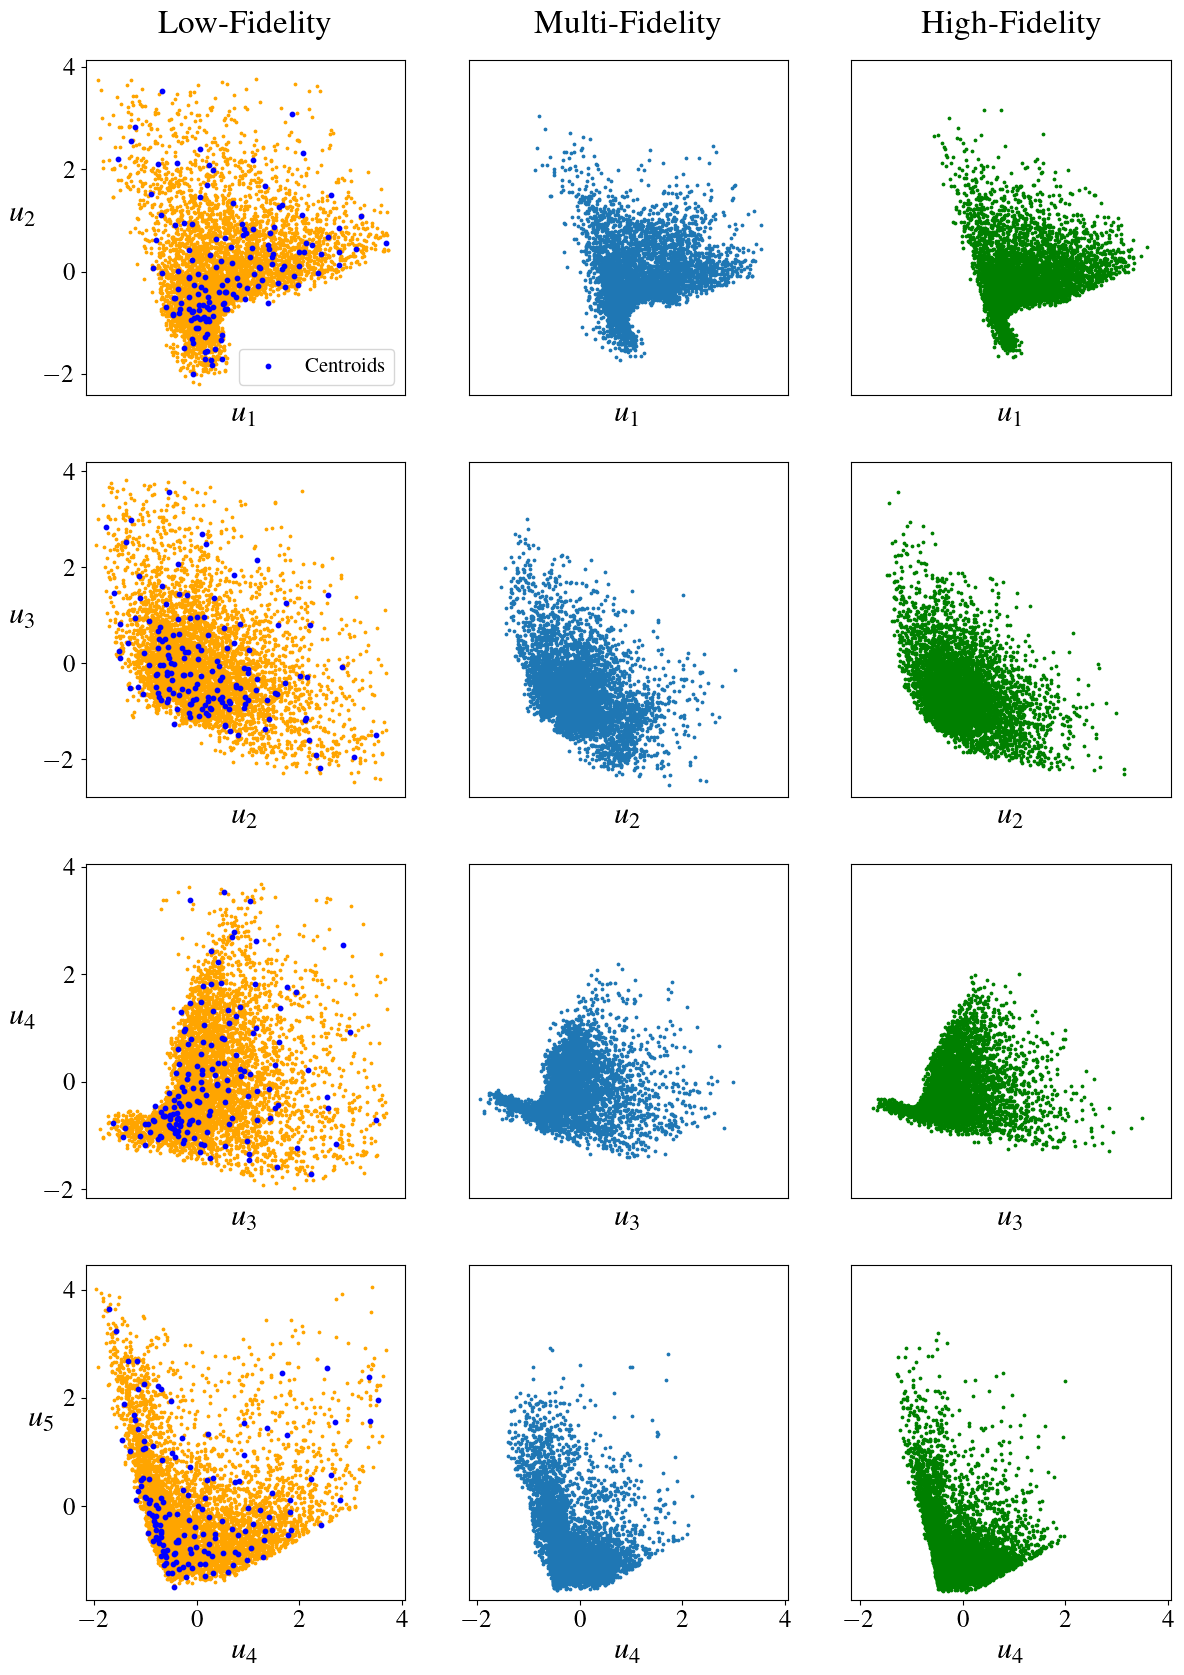

In [24]:
_plot_mf_comparison_qoi(X_LF=x_LF, X_MF=x_MF, X_HF=x_HF, inds_centroids=inds_train)

### Explore UQ applications

In [28]:
import matplotlib.ticker as ticker

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [ ]:
# Plot error vs model uncertainty
import scipy.stats

y_ = np.linalg.norm(x_MF - x_HF, axis=1)
x_ = dPhi

mask_ = (y_ < 5) 
x_, y_ = x_[mask_], y_[mask_]

x = (x_ - np.mean(x_)) / np.std(x_)
y = (y_ - np.mean(y_)) / np.std(y_)

corr, _ = scipy.stats.pearsonr(x, y)
print(f"correlation = {corr}")

x_plot = np.linspace(-1, 6, 10).reshape(-1, 1)
y_plot = x_plot

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(x, y, s=3)
ax.set_aspect('equal', 'box')
ax.plot(x_plot, y_plot, c='r', linewidth=2)
ax.set_xlabel('Model uncertainty', fontsize=20, labelpad=10)
ax.set_ylabel('Model error', fontsize=20, labelpad=10)
ax.tick_params(axis='both', labelsize=14)
ax.grid("on")

In [30]:
g_MF = Graph(data=x_MF, **graph_config)

In [ ]:
_, eigevs = g_MF.laplacian_eig()
X = np.real(eigvecs[:, :n_HF])

In [ ]:
import umap

X_umap = umap.UMAP(
    n_components=2,
    n_neighbors=40,
    min_dist=0.75,
    init='random', 
    random_state=42
).fit_transform(X)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9.5))
ax1 = ax.scatter(X_umap[:, 0], X_umap[:, 1], s=15, c=dPhi, vmin=0.015)
ax.scatter(X_umap[inds_train, 0], X_umap[inds_train, 1], s=30, c='r', marker='o')
cb = plt.colorbar(ax1, format=ticker.FuncFormatter(fmt))
cb.ax.tick_params(labelsize=16)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('UMAP of Elastic Body data (Case 1)', fontsize=26, pad=10)

In [ ]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2,
              random_state=42,
              perplexity=100,
              early_exaggeration=10,).fit_transform(X)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9.5))
ax1 = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], s=15, c=dPhi)
ax.scatter(X_tsne[inds_train, 0], X_tsne[inds_train, 1], s=30, c=dPhi[inds_train], marker='o')
cb = plt.colorbar(ax1, format=ticker.FuncFormatter(fmt))
cb.ax.tick_params(labelsize=16)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('t-SNE of Elastic Body data (case 1)', fontsize=26, pad=10)